In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
device = 'cuda:0'

from torchvision import transforms
from torch.utils.data import DataLoader
# from torch_custom_dataloader import GorillaDataset, build_label_index
from spac_gorillaloader import GorillaDataset, load_datapoints
import torch

batch_size = 32

datapoints = load_datapoints()

dataset_train = GorillaDataset(datapoints=datapoints, percent_start=0, percent_end=70)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_val = GorillaDataset(datapoints=datapoints, percent_start=70, percent_end=85)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

dataset_test = GorillaDataset(datapoints=datapoints, percent_start=85, percent_end=100)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)


In [ ]:
import timm

#model = timm.create_model('resnet18.a1_in1k', in_chans=3, num_classes=len(label_mapping), pretrained=True)

# Create a ViT model for 3-channel input and 42 output classes
model = timm.create_model(
    'vit_base_patch16_224',
    pretrained=True,
    in_chans=3
)

In [ ]:
from typing import List, Tuple
import torch
import wandb
from torch import nn, optim
from gorilla_model import train


epochs = 10
learning_rate = 0.001

train(
    model,
    epochs=epochs,
    learning_rate=learning_rate,
    dataloader_train=dataloader_train,
    dataloader_val=dataloader_val
)

    # TODO: would implement something good here :D
    # if val_avg_loss < prev_val_loss:
    #   prev_val_loss = val_avg_loss
    # else:
    #   print(f"Killed early, no smaller loss. {val_avg_loss} vs. {prev_val_loss}")
    #   break


In [ ]:
torch.save(model.state_dict(), 'face_model.pth')

In [2]:
import random
import matplotlib.pyplot as plt
import timm
from tqdm.notebook import tqdm
from visualize import visualize_embeddings
import numpy as np
import torch
from spac_gorillaloader import GorillaDataset, load_datapoints
from torch.utils.data import DataLoader

device = 'cuda:0'

loaded_model = timm.create_model(
    'vit_base_patch16_224',
    pretrained=True,
    in_chans=3
)

weights = torch.load('face_model.pth', map_location=device)
loaded_model.load_state_dict(weights)
loaded_model = loaded_model.to(device)

# Load model weights into the model
loaded_model.eval()

batch_size = 32

datapoints = load_datapoints()

dataset_vis = GorillaDataset(datapoints=datapoints, percent_start=0, percent_end=100)
dataloader_vis = DataLoader(dataset_vis, batch_size=batch_size, shuffle=True)

all_embeddings = []
all_labels = []

label_mapping = {}

with torch.no_grad():
    total_files=len(dataloader_vis)
    pbar = tqdm(total=total_files, desc="Visualizing embeddings...")
    for [idx, batch] in enumerate(dataloader_vis):
        labels, this_class, _, _ = batch

        for label in labels:
            #print(f"label: {label}")
            if label not in label_mapping:
                label_mapping[label] = len(label_mapping)
            mapped = label_mapping[label]
            all_labels.append(mapped)

        this_class = this_class.to(device)
        output_emb = loaded_model(this_class)

        #all_labels.append(label_mapping[label])F
        all_embeddings.append(output_emb.cpu())
        pbar.update(1)

all_embeddings = torch.cat(all_embeddings, dim=0) 


Using DP cache...
Deleted 15 datapoints due to data distribution.
GORILLA_DATA: Using data from index 0 to 604, covering 604, total 865 DP.
Using DP cache...
Deleted 9 datapoints due to data distribution.
GORILLA_DATA: Using data from index 0 to 864, covering 864, total 865 DP.


Visualizing embeddings...:   0%|          | 0/27 [00:00<?, ?it/s]

Computing PCA...


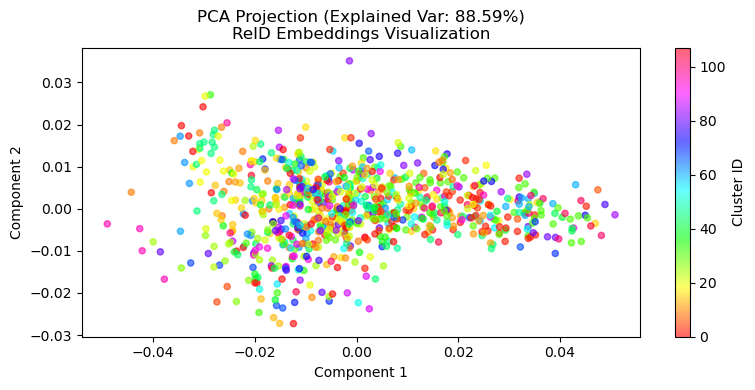


Visualization complete!
Original embedding dimension: 1000
Number of samples: 855
Number of unique clusters: 108
Computing t-SNE...


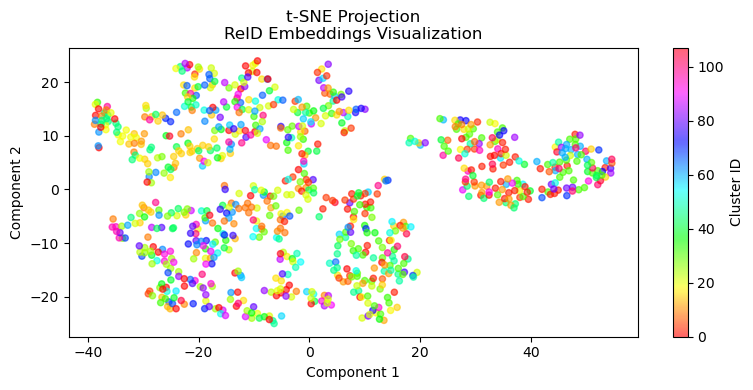


Visualization complete!
Original embedding dimension: 1000
Number of samples: 855
Number of unique clusters: 108


In [3]:
visualize_embeddings(all_embeddings, all_labels, method='psa', figsize=(8, 4))
visualize_embeddings(all_embeddings, all_labels, method='tsne', figsize=(8, 4))